<a href="https://colab.research.google.com/github/BhojRajBist/BhojRajBist/blob/main/Copy_of_FireDataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import numpy as np
    import rasterio
    from rasterio.plot import show
    import matplotlib.pyplot as plt
    import geopandas as gpd
    from rasterio import features
    from tqdm.notebook import tqdm
except ImportError as e:
    missing_package = str(e).split()[-1][1:-1]  # Extract the name of the missing package
    print(f"Installing missing package: {missing_package}")
    !pip install {missing_package}

# Now importing again after installation
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio import features
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Ensure Google Drive is mounted

import os

Mounted at /content/drive


In [ ]:
src = rasterio.open("/content/drive/MyDrive/nou_practical/Dataset/227073_2019-07-31_10_09.tif")
img = src.read()
img.shape

(6, 5055, 5308)

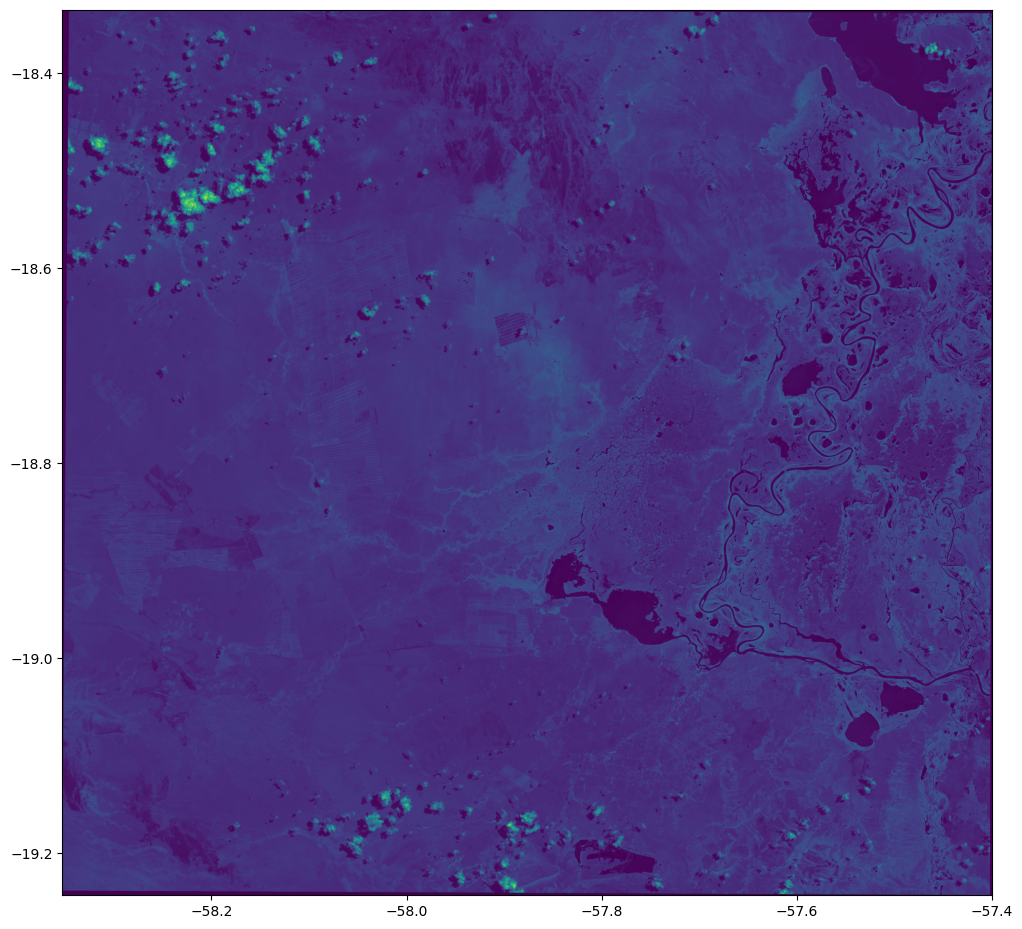

In [ ]:
img_vis = img[4, :, :]
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img_vis, transform=src.transform, ax=ax)
ax.ticklabel_format(useOffset=False, style="plain")

In [ ]:
GroundTruth = gpd.read_file("/content/drive/MyDrive/nou_practical/Dataset/GT_v1.gpkg").to_crs(epsg=4326)

<Axes: >

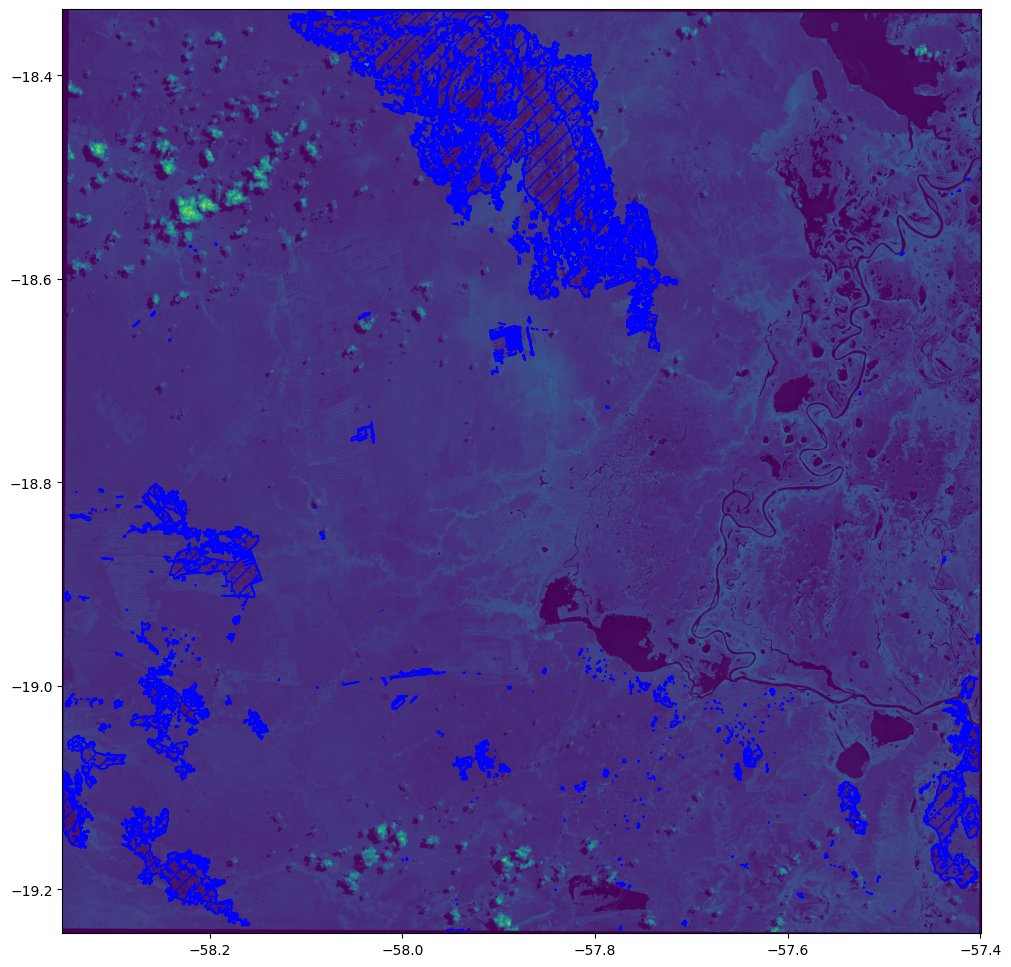

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img_vis, transform=src.transform, ax=ax)
ax.ticklabel_format(useOffset=False, style="plain")
GroundTruth.plot(ax=ax, color="none", edgecolor="blue", hatch="//")

In [ ]:
shapes = ((geom, 1) for geom in GroundTruth.geometry)
raster_GT = features.rasterize(
    shapes=shapes, fill=0, out_shape=img[0].shape, transform=src.transform
)

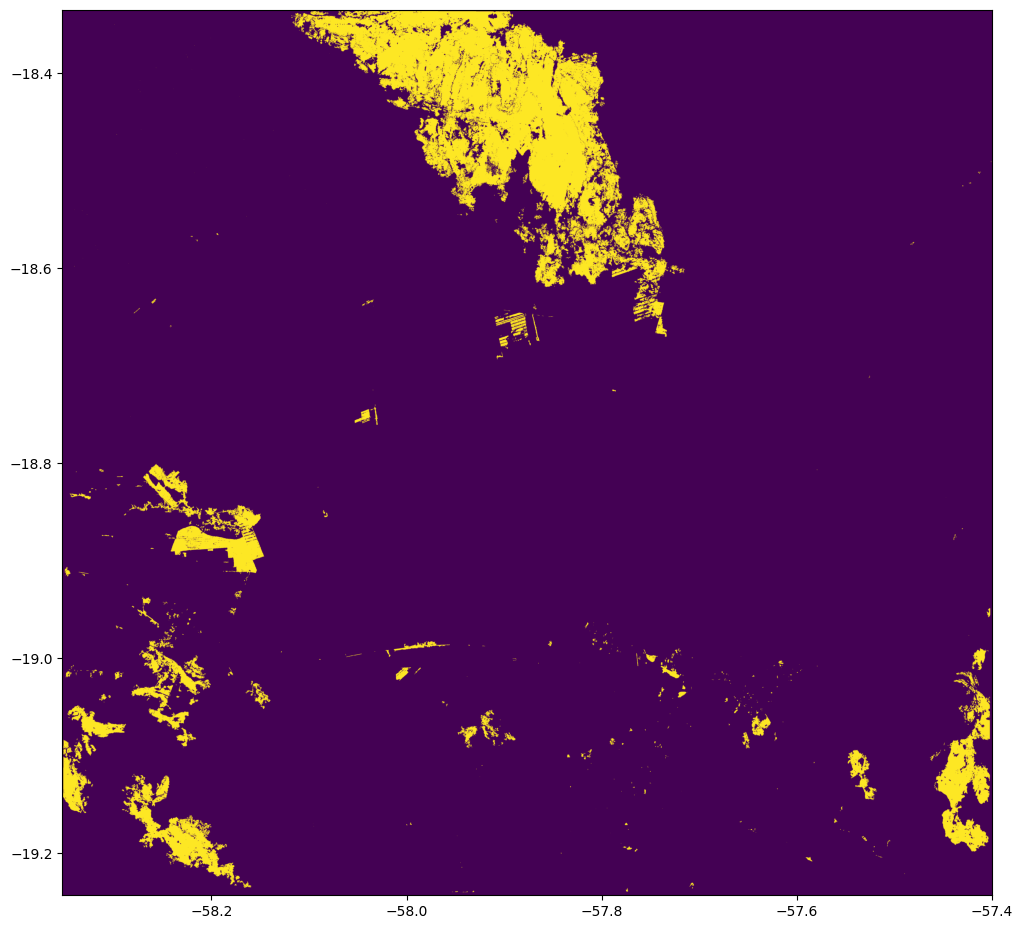

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 12))
show(raster_GT, transform=src.transform, ax=ax)
ax.ticklabel_format(useOffset=False, style="plain")

In [ ]:
XData = img.transpose((1, 2, 0))
YData= np.expand_dims(raster_GT, -1)
#YData = raster_GT.transpose((1, 2, 0))


In [ ]:
print(img.shape)
print(raster_GT.shape)

(6, 5055, 5308)
(5055, 5308)


In [ ]:
print(XData.shape)
print(YData.shape)


(5055, 5308, 6)
(5055, 5308, 1)


In [ ]:
NBANDS = XData.shape[-1]
print(NBANDS)

6


In [ ]:
#PATCHSIZE = 32
PATCHSIZE =32
NBANDS = XData.shape[-1]

def gridwise_sample(ximg, yimg, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner."""
    nrows, ncols, nbands = ximg.shape
    first = True
    for i in tqdm(range(int(nrows / patchsize))):
        for j in range(int(ncols / patchsize)):
            xpatch = ximg[
                i * patchsize : (i + 1) * patchsize,
                j * patchsize : (j + 1) * patchsize,
                :,
            ]
            ypatch = yimg[
                i * patchsize : (i + 1) * patchsize,
                j * patchsize : (j + 1) * patchsize,
                :,
            ]
            xpatch = np.expand_dims(xpatch, axis=0)
            ypatch = np.expand_dims(ypatch, axis=0)
            if not (np.any(np.isnan(xpatch)) or np.any(np.isnan(ypatch))):
                if first:
                    xpatches,ypatches = xpatch,ypatch
                    first = False
                else:
                    xpatches = np.concatenate((xpatches, xpatch), axis=0)
                    ypatches = np.concatenate((ypatches, ypatch), axis=0)
    return xpatches,ypatches


XPatches,YPatches = gridwise_sample(XData,YData, PATCHSIZE)

print("There are %i number of image patches" % (XPatches.shape[0]))

  0%|          | 0/157 [00:00<?, ?it/s]

There are 25905 number of image patches


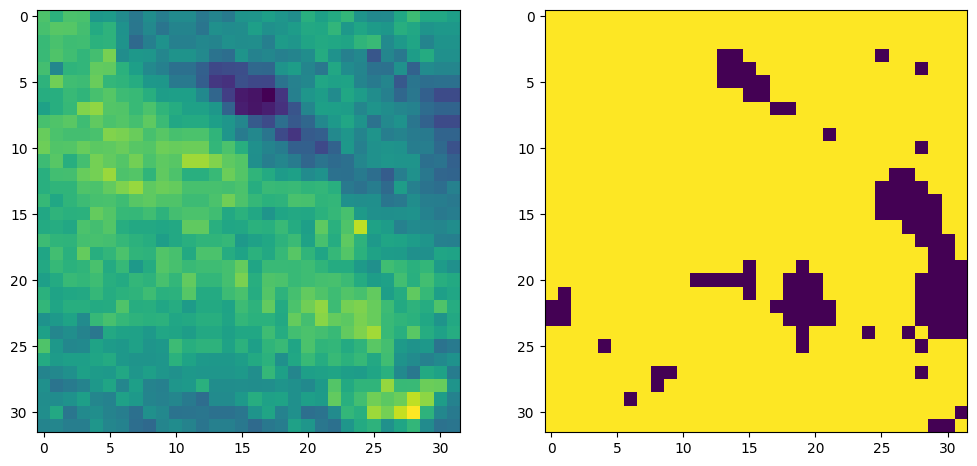

In [ ]:
#n = 180  # sample number
n = 555
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(XPatches[n, :, :, 2])
ax[1].imshow(YPatches[n, :, :, 0])

ax[0].ticklabel_format(useOffset=False, style="plain")
ax[1].ticklabel_format(useOffset=False, style="plain")

In [ ]:
np.save("/content/drive/MyDrive/nou_practical/Dataset/XData_v3.npy", XPatches)
np.save("/content/drive/MyDrive/nou_practical/Dataset/YData_v3.npy", YPatches)

In [ ]:
print(XPatches.shape)
YPatches.shape

(25905, 32, 32, 6)


(25905, 32, 32, 1)